In [177]:
import numpy as np
import cv2
from hdrtool import hdr
from hdrtool import align
import pandas as pd
import os
import importlib
import time
import matplotlib.pyplot as plt
import os

In [195]:
IMGDIR = './example/park3'
META = './example/park3.csv'
OUTPUT_PATH = os.path.basename(IMGDIR)+'-output.jpg'
HDR_PATH = os.path.basename(IMGDIR)+'output.hdr'

## Load Meta Data

In [196]:
df = pd.read_csv(META, sep='\s+')

In [197]:
if 'exposetime' not in df.columns:
    df['exposetime'] = 1/df['1/shutter_speed']

In [198]:
if len(df) > 8:
    mid = len(df)//2
    df = df[2:mid+2].reset_index()

In [199]:
df

,Filename,exposetime
0,IMG_7189.JPG,0.25
1,IMG_7190.JPG,1.00
2,IMG_7191.JPG,4.00
3,IMG_7192.JPG,15.00


In [200]:
# read the images
imgs = [cv2.resize(cv2.imread(os.path.join(IMGDIR,fn)),(960, 540)) for fn in df.Filename]

## Image alignment

In [201]:
image_alignment = align.ImageAlignment()

def solve_alignment(images, d=5):
    for i in range(1, len(images)):
        print('\r[Alignment] %d' % (i + 1), end='')
        images[i] = image_alignment.fit(images[i], images[i-1], d)
    print()
    return images

### This is opitonal
#imgs = solve_alignment(imgs)

## Plotting images

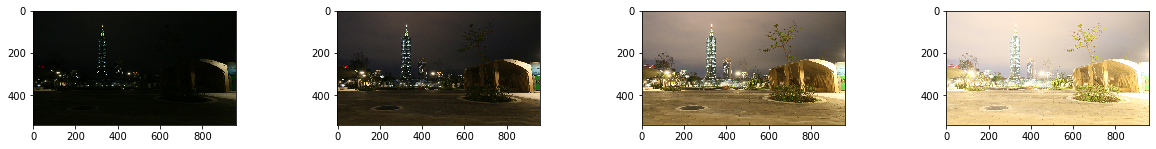

In [202]:
fig=plt.figure(figsize=(20, 10))
columns = len(imgs)
rows = 1
for i in range(1, columns*rows+1):
    img = imgs[i-1]
    fig.subplots_adjust(wspace=0.5)
    fig.add_subplot(rows, columns, i)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) #Opencv use BGR instead of RGB
    #plt.plot([190],[130], 'bo')
plt.show()

## Compute HDR

In [203]:
#relode module
importlib.reload(hdr)
importlib.reload(align)

<module 'hdrtool.align' from '/home/tsai/workspace/high-dynamic-range-image/hdrtool/align.py'>

In [204]:
df.exposetime

0     0.25
1     1.00
2     4.00
3    15.00
Name: exposetime, dtype: float64

In [205]:
hdrimg = hdr.computeHDR(imgs, np.log(df.exposetime).astype(np.float32))

channel: 0
    sampling intensities...
    running time: 1.4541676044464111
    computing response curve...
    running time: 0.40721774101257324
    building irradiance map using np...
    running time: 8.558273792266846
channel: 1
    sampling intensities...
    running time: 1.4544339179992676
    computing response curve...
    running time: 0.42185354232788086
    building irradiance map using np...
    running time: 8.503724336624146
channel: 2
    sampling intensities...
    running time: 1.4533710479736328
    computing response curve...
    running time: 0.4126300811767578
    building irradiance map using np...
    running time: 8.550266027450562


In [206]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker

def plot_radiance(radiance, colors= ['Blue', 'Green', 'Red']):
    print('[Plot] radiance')
    def fmt(x, pos): return '%.3f' % np.exp(x)

    height, width, channels = radiance.shape
    ln_radiance = np.log(radiance)

    plt.clf()
    fig, ax = plt.subplots(1, channels, figsize=(5 * channels, 5))

    for c in range(channels):
        im = ax[c].imshow(ln_radiance[:, :, c], cmap='jet')
        ax[c].set_title(colors[c])
        ax[c].set_axis_off()
        divider = make_axes_locatable(ax[c])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax, format=ticker.FuncFormatter(fmt))

### plotting HDR image

[Plot] radiance


<Figure size 432x288 with 0 Axes>

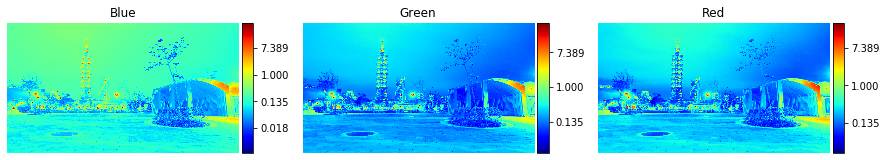

In [207]:
plot_radiance(hdrimg, ['Blue', 'Green', 'Red'])

In [208]:
# save high dynamic range image
cv2.imwrite(HDR_PATH, hdrimg)

True

### Global Tone Mapping and Plotting

#### with lower key

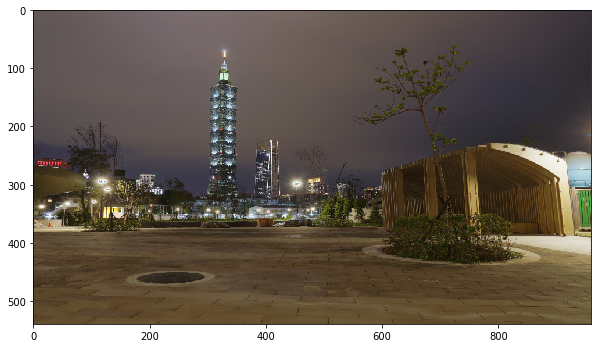

In [212]:
# map hdr image to 0-255
hdr_mapped = hdr.globalToneMapping(hdrimg, Lwhite=np.exp(hdrimg.max())*0.8, alpha=0.4)
cv2.imwrite(OUTPUT_PATH, (hdr_mapped).astype(np.uint8) )
# plotting
plt.figure(figsize=(10, 17))
plt.imshow(cv2.cvtColor((hdr_mapped).astype(np.uint8), cv2.COLOR_BGR2RGB))

#### with higher key

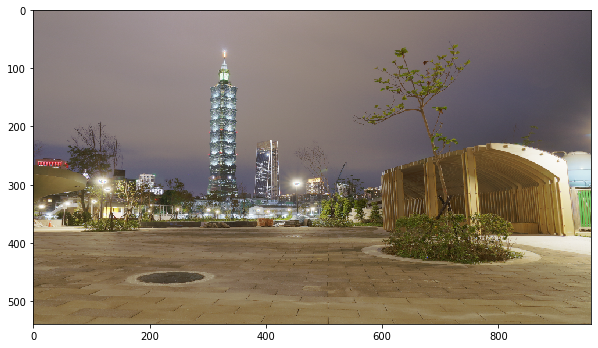

In [211]:
hdr_mapped = hdr.globalToneMapping(hdrimg, Lwhite=np.exp(hdrimg.max())*0.9, alpha=0.8)

plt.figure(figsize=(10, 17))
plt.imshow(cv2.cvtColor((hdr_mapped).astype(np.uint8), cv2.COLOR_BGR2RGB))